# 量子計算の基礎

In [ ]:
!pip install --upgrade qiskit
!pip install --upgrade qiskit-ibm-runtime

In [41]:
import numpy as np

import matplotlib.pyplot as plt

In [8]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator, SamplerV2 as Sampler
from qiskit.quantum_info import SparsePauliOp
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.primitives import BackendEstimatorV2 as BackendEstimator, BackendSamplerV2 as BackendSampler
from qiskit.providers.basic_provider import BasicProvider 
from qiskit.primitives import StatevectorEstimator, StatevectorSampler

ここでは主にqiskitを用いて量子多体系の計算を行う方法について学ぶ

目標
* 横磁場イジング模型の時間発展を計算できるようになる

応用
* 量子多体傷跡状態の非平衡ダイナミクスを解析する


# Suzuki-Lie-Trotter分解

実時間Schrodinger方程式 $i\partial_t|\psi(t)\rangle=H|\psi(t)\rangle$ を解くことが目標である

量子回路上で実装するためにはユニタリ演算子を作用する形で表す必要がある

最も単純には$|\psi(t)\rangle={\rm e}^{-{\rm i}Ht}|\psi(0)\rangle$だろう

${\rm e}^{-{\rm i}Ht}$はこのままでは非常に複雑な演算子であるため, 単純な演算子の組み合わせに分解する必要がある

ここでは最も単純な場合のSuzuki-Lie-Trotter分解を紹介する

$H=H_1+H_2$という形のハミルトニアンを考える

$H_1$と$H_2$はそれぞれ可換な（パウリ）演算子の集まりで, $H_1$と$H_2$は非可換であるとする

シミュレーションしたい時間幅を$t$, 時間の刻み幅を$dt$, t進めるまでに必要なアップデートの回数を$M=\frac{t}{dt}$として,

$e^{-{\rm i}t H}=\left(e^{-{\rm i}dt H_1}e^{-{\rm i}dt H_2}\right)^{M}+Mdt^2O(||[H_1,H_2]||)$

誤差は大雑把に$\varepsilon=Mdt^2O(||[H_1,H_2]||)\sim Ntdt$なので, 誤差を保って計算するためには$dt\propto t^{-1}N^{-1}$でスケールさせる必要がある

より一般に$p$次のSuzuki-Lie-Trotter分解の場合は$\varepsilon\sim NMdt^{p+1}=Nt dt^p$なので$dt\propto t^{-\frac{1}{p}}N^{-\frac{1}{p}}$でスケールさせる必要がある

ゲート数に換算する場合は$\sim M N=t^{1+\frac{1}{p}}N^{1+\frac{1}{p}}$ (ハミルトニアンの項の数が$N$個程度の場合)

## 横磁場イジング模型の量子クエンチ

回路型量子計算を用いて古典計算でシミュレーションした熱化の問題を解いてみよう

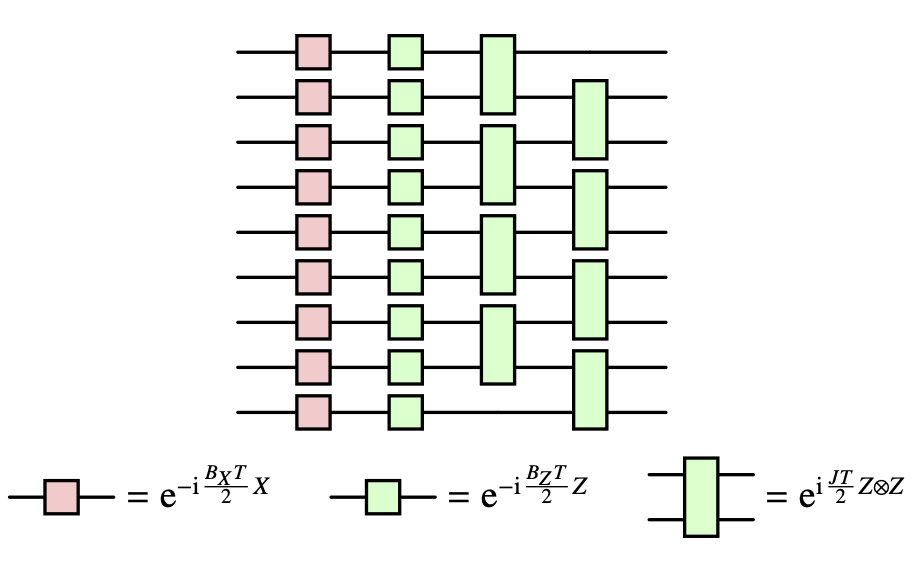

$H_1=-\sum_{n=1}^{N-1} Z_nZ_{n+1}+B_Z \sum_{n=1}^N Z_n$ (解放境界条件の場合)

$H_2= B_X \sum_{n=1}^N X_n$

1次のTrotter分解: $U=e^{-{\rm i} \frac{T}{2}H_1}e^{-{\rm i} \frac{T}{2}H_2}$ ($dt=\frac{T}{2}$)

時間発展: $|\psi(t)\rangle=U^{M}|\psi(0)\rangle$ ($M=\frac{t}{dt}$)

実際のシミュレーションでコードを書く際の手順を簡単にまとめる

* 各ボックスの量子ゲートを定義する

* 1ステップの量子ゲートをボックスから作成する

* nステップの各ボックス量子ゲートを作成する

* 初期状態を準備する量子ゲートを作成する

* 測定を行う量子ゲートを作成する

* これらを結合して実行する

In [202]:
def X(qc,q,theta):
    """
    exp(-i*theta*X)
    """
    qc.rx(2*theta,q)
        
def Z(qc,q,theta):
    """
    exp(-i*theta*Z)
    """
    qc.rz(2*theta,q)
        
def ZZ(qc,q0,q1,theta):
    """
    exp(-i*theta*Z0*Z1)
    """
    qc.cx(q0,q1)
    qc.rz(2*theta,q1)
    qc.cx(q0,q1)

def CX(qc,q0,q1,theta):
    """
    c-exp(-i*theta*X1); q0 is the control qubit
    """
    qc.h(q1)
    qc.rz(theta,q1)
    qc.cx(q0,q1)
    qc.rz(-theta,q1)
    qc.cx(q0,q1)
    qc.h(q1)

def CZ(qc,q0,q1,theta):
    """
    c-exp(-i*theta*Z1); q0 is the control qubit
    """
    qc.rz(theta,q1)
    qc.cx(q0,q1)
    qc.rz(-theta,q1)
    qc.cx(q0,q1)

def CZZ(qc,q0,q1,q2,theta):
    """
    c-exp(-i*theta*Z1*Z2); q0 is the control qubit
    """
    qc.ccx(q0,q1,q2)
    CZ(qc,q0,q2,theta)
    qc.ccx(q0,q1,q2)

In [244]:
def U_ising(qc,q,h,m,dt):
    """
    exp(-i*dt*H_ising)
    h: coeff of transverse field
    m: coeff of longitudinal field
    """
    N = len(q)

    for i in range(N):
        X(qc,q[i],h*dt)

    for i in range(N):
        Z(qc,q[i],m*dt)

    for i in range(N-1):
        ZZ(qc,q[i],q[i+1],dt)
    ZZ(qc,q[N-1],q[0],dt)

def U_ising_dag(qc,q,h,m,dt):
    """
    exp(-i*dt*H_ising)
    h: coeff of transverse field
    m: coeff of longitudinal field
    """
    N = len(q)

    ZZ(qc,q[N-1],q[0],-dt)
    for i in reversed(range(N-1)):
        ZZ(qc,q[i],q[i+1],-dt)

    for i in range(N):
        Z(qc,q[i],-m*dt)

    for i in range(N):
        X(qc,q[i],-h*dt)

def cU_ising(qc,q,h,m,dt):
    """
    c-exp(-i*dt*H_ising)
    This is used to compute the vacuum persistence amplitude
    h: coeff of transverse field
    m: coeff of longitudinal field
    q[0] is the control qubit; N+1 qubits in total
    """
    Nq = len(q)

    for i in range(1,Nq):
        CX(qc,q[0],q[i],h*dt)

    for i in range(1,Nq):
        CZ(qc,q[0],q[i],m*dt)

    for i in range(1,Nq-1):
        CZZ(qc,q[0],q[i],q[i+1],dt)
    CZZ(qc,q[0],q[Nq-1],q[1],dt)

def swap(qc,q1,q2):
    N = len(q1)

    for i in range(N//2):
        qc.swap(q1[i],q2[i])

def cswap(qc,q0,q1,q2):
    N = len(q1)

    for i in range(N//2):
        qc.cswap(q0,q1[i],q2[i])

# 実行する

In [256]:
class TFI:
    def __init__(self,N,h,m,T,dt):
        self.N = N
        self.h = h
        self.m = m
        self.dt= dt
        self.M = int(T/dt)

    def measurement(self):

        X    = np.zeros(self.M+1)
        Xerr = np.zeros(self.M+1)

        ZZ    = np.zeros(self.M+1)
        ZZerr = np.zeros(self.M+1)

        for i in range(self.M+1):

            backend = BasicSimulator()
            q = QuantumRegister(self.N,"q")
            qc = QuantumCircuit(q)
            
            op1= [('X' ,[self.N//4],1.0)]
            op1=SparsePauliOp.from_sparse_list(op1 , num_qubits=len(q))
            op2= [('ZZ',[0,self.N//2],1.0)]
            op2=SparsePauliOp.from_sparse_list(op2 , num_qubits=len(q))
            op=[op1,op2]

            for _ in range(i):
                U_ising(qc,q,self.h,self.m,self.dt)

            estimator= BackendEstimator(backend=backend)
            result = estimator.run([(qc,op)]).result()[0].data
            X[i],ZZ[i]=result.evs
            Xerr[i],ZZerr[i]=result.stds
        return X,Xerr,ZZ,ZZerr
    
    def vacuum(self,shots=1000):

        P    = np.zeros(self.M+1)

        for i in range(self.M+1):

            backend = BasicSimulator()
            q = QuantumRegister(self.N,"q")
            c = ClassicalRegister(self.N,'c')
            qc = QuantumCircuit(q,c)

            for _ in range(i):
                U_ising(qc,q,self.h,self.m,self.dt)

            qc.measure(q, c)
            sampler= BackendSampler(backend=backend)
            P[i] = sampler.run([(qc)],shots=shots).result()[0].data.c.get_counts()['0'*self.N]/shots 

        return P

    def renyi2(self,shots=100):

        S    = np.zeros(self.M+1)

        for i in range(self.M+1):

            backend = BasicSimulator()
            q1 = QuantumRegister(self.N,"q1")
            q2 = QuantumRegister(self.N,"q2")
            qc = QuantumCircuit(q1,q2)

            for _ in range(i):
                U_ising(qc,q1,self.h,self.m,self.dt)

            for _ in range(i):
                U_ising(qc,q2,self.h,self.m,self.dt)

            swap(qc,q1,q2) 

            for _ in range(i):
                U_ising_dag(qc,q1,self.h,self.m,self.dt)

            for _ in range(i):
                U_ising_dag(qc,q2,self.h,self.m,self.dt)

            qc.measure_all() 

            sampler= BackendSampler(backend=backend)
            S[i] = -0.5*np.log(sampler.run([(qc)],shots=shots).result()[0].data.meas.get_counts()['0'*2*self.N]/shots)

        return S

    def vacuum_hadamard_re(self):

        P    = np.zeros(self.M+1)
        Perr = np.zeros(self.M+1)

        for i in range(self.M+1):

            backend = BasicSimulator()
            q = QuantumRegister(self.N+1,"q")
            qc = QuantumCircuit(q)
            qc.h(q[0])

            for _ in range(i):
                cU_ising(qc,q,self.h,self.m,self.dt)

            op= [('X' ,[0],1.0)]
            op=SparsePauliOp.from_sparse_list(op , num_qubits=len(q))

            estimator= BackendEstimator(backend=backend)
            result = estimator.run([(qc,op)]).result()[0].data
            P[i]=result.evs
            Perr[i]=result.stds

        return P,Perr

    def vacuum_hadamard_im(self):

        P    = np.zeros(self.M+1)
        Perr = np.zeros(self.M+1)

        for i in range(self.M+1):

            backend = BasicSimulator()
            q = QuantumRegister(self.N+1,"q")
            qc = QuantumCircuit(q)
            qc.h(q[0])
            qc.sdg(q[0])

            for _ in range(i):
                cU_ising(qc,q,self.h,self.m,self.dt)

            op= [('X' ,[0],1.0)]
            op=SparsePauliOp.from_sparse_list(op , num_qubits=len(q))

            estimator= BackendEstimator(backend=backend)
            result = estimator.run([(qc,op)]).result()[0].data
            P[i]=result.evs
            Perr[i]=result.stds

        return P,Perr

    def renyi2_hadamard(self):

        S    = np.zeros(self.M+1)
        Serr = np.zeros(self.M+1)

        for i in range(self.M+1):

            backend = BasicSimulator()
            q0 = QuantumRegister(1,"q0")
            q1 = QuantumRegister(self.N,"q1")
            q2 = QuantumRegister(self.N,"q2")
            qc = QuantumCircuit(q0,q1,q2)

            qc.h(q0)

            for _ in range(i):
                U_ising(qc,q1,self.h,self.m,self.dt)

            for _ in range(i):
                U_ising(qc,q2,self.h,self.m,self.dt)

            cswap(qc,q0,q1,q2) 

            op= [('X' ,[0],1.0)]
            op=SparsePauliOp.from_sparse_list(op , num_qubits=1+2*len(q1))

            estimator= BackendEstimator(backend=backend)
            result = estimator.run([(qc,op)]).result()[0].data
            S[i]=-np.log(result.evs)
            Serr[i]=result.stds/result.evs

        return S, Serr
    

In [226]:
N=10
hx=1.05
hz=0.5
T=2.5
dt=0.05

In [227]:
q=TFI(N,hx,hz,T,dt)

In [228]:
x,xerr,z,zerr=q.measurement()

In [230]:
p=q.vacuum()
p2r,p2rerr=q.vacuum_hadamard_re()
p2i,p2ierr=q.vacuum_hadamard_im()

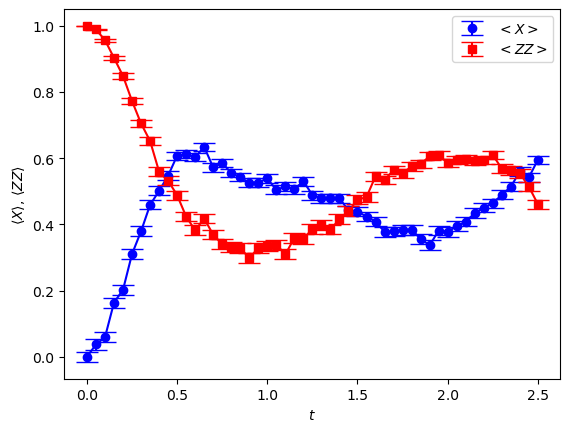

In [231]:
times= dt*np.arange(int(T/dt)+1)
plt.errorbar(times,x,yerr=xerr, fmt='o', capsize=8, color='blue',label=r"$<X>$")
plt.plot(times,x, 'b-')
plt.errorbar(times,z,yerr=zerr, fmt='s', capsize=8, color='red',label=r"$<ZZ>$")
plt.plot(times,z, 'r-')

plt.xlabel("$t$")
plt.ylabel(r"$\langle X\rangle$, $\langle ZZ\rangle$")
plt.legend()
plt.show()

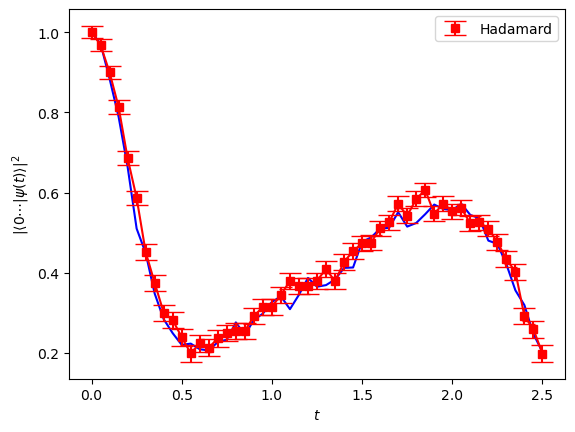

In [234]:
times= dt*np.arange(int(T/dt)+1)
plt.plot(times,p, 'b-')

p2=p2r**2+p2i**2
p2err=np.sqrt(p2rerr**2+p2ierr**2)

plt.errorbar(times,p2,yerr=p2err, fmt='s', capsize=8, color='red',label=r"Hadamard")
plt.plot(times,p2, 'r-')

plt.xlabel("$t$")
plt.ylabel(r"$\left|\langle 0\cdots|\psi(t)\rangle\right|^2$")

plt.legend()
plt.show()

In [257]:
N=6
hx=1.05
hz=0.5
T=2.5
dt=0.05
q=TFI(N,hx,hz,T,dt)

In [258]:
s=q.renyi2()
s2,s2err=q.renyi2_hadamard()

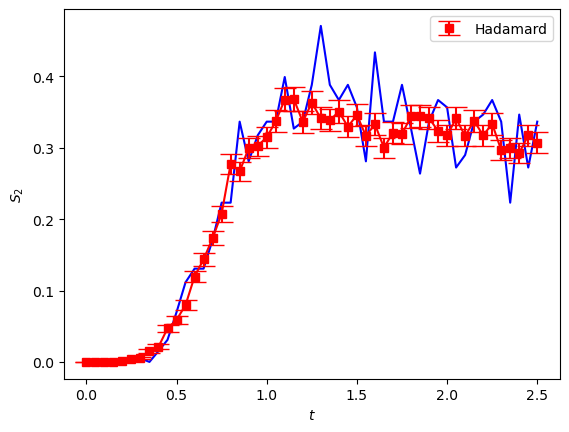

In [259]:
times= dt*np.arange(int(T/dt)+1)
plt.plot(times,s, 'b-')

plt.errorbar(times,s2,yerr=s2err, fmt='s', capsize=8, color='red',label=r"Hadamard")
plt.plot(times,s2, 'r-')

plt.xlabel("$t$")
plt.ylabel(r"$S_2$")

plt.legend()
plt.show()

### **問**

TFI模型についてパラメータを変えて熱化の計算を行なってみよ. 

### **問**

TFI模型について初期状態 (Xの固有状態, Anti-ferroの基底状態, Domain-wallのある状態を用意する...)を変えて熱化の計算を行なってみよ. 

### **問**

PXP模型: $H=-\sum_{i=1}^{N}P_{i-1}X_i P_{i+1}$について$|\psi(0)\rangle=|\uparrow\cdots\uparrow\rangle$, $|\psi(0)\rangle=|\uparrow\downarrow\cdots\uparrow\downarrow\rangle$を初期条件として熱化の計算を行なってみよ. 

ただし, $P_i$は$i$番目の量子ビットを$\uparrow$状態に射影する演算子$P_i=|\uparrow_i\rangle\langle\uparrow_i|$である

PXPで新たに必要なゲートは以下を用いよ

In [ ]:
def ZX(qc,q0,q1,theta):
    """
    exp(-i*theta*Z0*X1)
    """
    qc.h(q1)
    qc.cx(q0,q1)
    qc.rz(2*theta,q1)
    qc.cx(q0,q1)
    qc.h(q1)

def CZX(qc,q0,q1,q2,theta):
    """
    c-exp(-i*theta*Z1*X2); q0 is the control qubit
    """
    qc.h(q2)
    qc.ccx(q0,q1,q2)
    CZ(qc,q0,q2,theta)
    qc.ccx(q0,q1,q2)
    qc.h(q2)

def ZZX(qc,q0,q1,q2,theta):
    """
    exp(-i*theta*Z0*Z1*X2)
    """
    qc.h(q2)
    qc.cx(q0,q2)
    qc.cx(q1,q2)
    qc.rz(2*theta,q2)
    qc.cx(q1,q2)
    qc.cx(q0,q2)
    qc.h(q2)

def CZZX(qc,q0,q1,q2,q3,theta):
    """
    c-exp(-i*theta*Z1*Z2*X3); q0 is the control qubit
    """
    qc.h(q3)
    qc.ccx(q0,q1,q3)
    qc.ccx(q0,q2,q3)
    qc.rz(2*theta,q3)
    qc.ccx(q0,q2,q3)
    qc.ccx(q0,q1,q3)
    qc.h(q3)


### **問**

古典計算で用いたハミルトニアンについて量子計算を用いて解析せよ

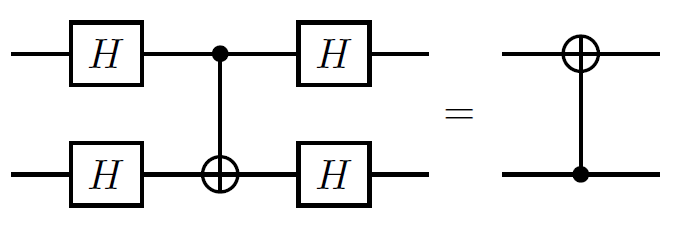

### 他のゲートの作り方

$R_{ZZ}$から$R_{XX}$, $R_{YY}$を作る

In [ ]:
def ZZ(qc,q0,q1,theta):
    """
    exp(-i*theta*Z0*Z1)
    """
    qc.cx(q0,q1)
    qc.rz(2*theta,q1)
    qc.cx(q0,q1)

def XX(qc,q0,q1,theta):
    """
    exp(-i*theta*X0*X1)
    """
    qc.cx(q0,q1)
    qc.rx(2*theta,q0)
    qc.cx(q0,q1)

def YY(qc,q0,q1,theta):
    """
    exp(-i*theta*Y0*Y1)
    """
    qc.sdg(q0); qc.sdg(q1)
    qc.cx(q0,q1)
    qc.rx(2*theta,q0)
    qc.cx(q0,q1)
    qc.s(q0); qc.s(q1)

同様にして$e^{-{\rm i}\theta Z\cdots Z}$を作り, 基底を変換することで$e^{-{\rm i}\theta X\cdots X}$ etc.を作ることができる